<a href="https://colab.research.google.com/github/mmcastillo/al112248/blob/main/Unet_aneurismas_custom_datagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install volumentations-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
pip install pypatchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive/');
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from scipy import ndimage
from sklearn.model_selection import train_test_split
from volumentations import *
import random
import os
import natsort
import glob
import pypatchify

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [21]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            X = X.astype(np.float32)  
            Y = Y.astype(np.float32)

            Z = img_list[batch_start:limit]

            yield (X,Y,Z) #a tuple with two numpy arrays with batch_size samples
           
            batch_start += batch_size   
            batch_end += batch_size

In [22]:
train_img_dir = '/content/drive/MyDrive/DOCTORADO/python/ADAM_10A_npy/train/imgs/';
train_mask_dir = '/content/drive/MyDrive/DOCTORADO/python/ADAM_10A_npy/train/masks/';
train_img_list = os.listdir(train_img_dir)
train_img_list = natsort.natsorted(train_img_list)
train_mask_list = os.listdir(train_mask_dir)
train_mask_list = natsort.natsorted(train_mask_list)

val_img_dir = '/content/drive/MyDrive/DOCTORADO/python/ADAM_10A_npy/val/imgs/';
val_mask_dir = '/content/drive/MyDrive/DOCTORADO/python/ADAM_10A_npy/val/masks/';
val_img_list = os.listdir(val_img_dir)
val_img_list = natsort.natsorted(val_img_list)
val_mask_list = os.listdir(val_mask_dir)
val_mask_list = natsort.natsorted(val_mask_list)

In [23]:
batch_size = 128

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


In [24]:
img,mask,Z = train_img_datagen.__next__()
print(img.shape)
print(mask.shape)
print(np.unique(mask))

#Encuentra los patches 3D donde las máscaras contienen valores 1 y 0 (donde hay aneurisams)
if np.unique(mask).shape[0]  == 2:
  for i in range(mask.shape[0]):
    if np.unique(mask[i,:,:,:]).shape[0] == 2: 
      n_patch_aneurisma = i
      print(f'En el patch número {n_patch_aneurisma+1} se encuentra el aneurisma')
      n_imagenes_aneurismas=[]
      for j in range(mask.shape[1]):
        if np.unique(mask[n_patch_aneurisma,j,:,:]).shape[0] == 2:
          print(f'En las imagenes {j+1}')

(128, 64, 64, 64, 1)
(128, 64, 64, 64, 1)
[0. 1.]
En el patch número 71 se encuentra el aneurisma
En las imagenes 21
En las imagenes 22
En las imagenes 23
En las imagenes 24
En las imagenes 25
En las imagenes 26
En las imagenes 27
En las imagenes 28
En las imagenes 29
En las imagenes 30
En las imagenes 31
En las imagenes 32
En las imagenes 33
En las imagenes 34
En las imagenes 35
En las imagenes 36


In [25]:
print(Z)

['2A1.npy', '2A2.npy', '2A3.npy', '2A4.npy', '2A5.npy', '2A6.npy', '2A7.npy', '2A8.npy', '2A9.npy', '2A10.npy', '2A11.npy', '2A12.npy', '2A13.npy', '2A14.npy', '2A15.npy', '2A16.npy', '2A17.npy', '2A18.npy', '2A19.npy', '2A20.npy', '2A21.npy', '2A22.npy', '2A23.npy', '2A24.npy', '2A25.npy', '2A26.npy', '2A27.npy', '2A28.npy', '2A29.npy', '2A30.npy', '2A31.npy', '2A32.npy', '2A33.npy', '2A34.npy', '2A35.npy', '2A36.npy', '2A37.npy', '2A38.npy', '2A39.npy', '2A40.npy', '2A41.npy', '2A42.npy', '2A43.npy', '2A44.npy', '2A45.npy', '2A46.npy', '2A47.npy', '2A48.npy', '2A49.npy', '2A50.npy', '2A51.npy', '2A52.npy', '2A53.npy', '2A54.npy', '2A55.npy', '2A56.npy', '2A57.npy', '2A58.npy', '2A59.npy', '2A60.npy', '2A61.npy', '2A62.npy', '2A63.npy', '2A64.npy', '2A65.npy', '2A66.npy', '2A67.npy', '2A68.npy', '2A69.npy', '2A70.npy', '2A71.npy', '2A72.npy', '2A73.npy', '2A74.npy', '2A75.npy', '2A76.npy', '2A77.npy', '2A78.npy', '2A79.npy', '2A80.npy', '2A81.npy', '2A82.npy', '2A83.npy', '2A84.npy', 

In [ ]:
images_path='/content/drive/MyDrive/DOCTORADO/python/aneurismas_seleccionados/imgs/' #path to original images
masks_path = '/content/drive/MyDrive/DOCTORADO/python/aneurismas_seleccionados/masks/' #path to original masks
img_augmented_path='/content/drive/MyDrive/DOCTORADO/python/aug/imgs/' # path to store augmented images
msk_augmented_path='/content/drive/MyDrive/DOCTORADO/python/aug/masks/' # path to store augmented masks
images=[] # to store paths of images from folder
masks=[]

for im in natsort.natsorted(os.listdir(images_path)):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in natsort.natsorted(os.listdir(masks_path)):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))

def get_augmentation(patch_size):
    return Compose([
        Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
        ElasticTransform((0, 0.25), interpolation=2, p=0.1),
        Flip(0, p=0.5),
        Flip(1, p=0.5),
        Flip(2, p=0.5),
        RandomRotate90((1, 2), p=0.5),
    ], p=1.0)

aug = get_augmentation((64, 64, 64))

images_to_generate = 50

i=1   # variable to iterate till images_to_generate

while i<=images_to_generate: 
    for j in range(8):
      number = j 
      image = images[number]
      mask = masks[number]
      #print(image, mask)

      original_image = np.load(image)
      original_mask = np.load(mask)

      data = {'image': original_image, 'mask': original_mask}
      aug_data = aug(**data)
      transformed_image, transformed_mask = aug_data['image'], aug_data['mask']

      new_image_path= "%saug_img_%sA%s.npy" %(img_augmented_path, number+2, i)
      new_mask_path = "%saug_mask_%sA%s.npy" %(msk_augmented_path,number+2 , i)
      np.save(new_image_path, transformed_image)
      np.save(new_mask_path, transformed_mask)
    i =i+1

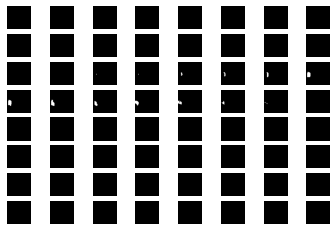

In [67]:
I = np.load('/content/drive/MyDrive/DOCTORADO/python/aug/imgs/aug_img_2A1.npy')
J = np.load('/content/drive/MyDrive/DOCTORADO/python/aug/masks/aug_mask_2A1.npy')

plt.subplot(1,2,1)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(J[:,:,i,0],cmap='gray')
  plt.axis('off')

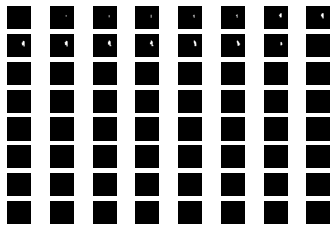

In [68]:
I = np.load('/content/drive/MyDrive/DOCTORADO/python/aug/imgs/aug_img_2A2.npy')
J = np.load('/content/drive/MyDrive/DOCTORADO/python/aug/masks/aug_mask_2A2.npy')

plt.subplot(1,2,1)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(J[:,:,i,0],cmap='gray')
  plt.axis('off')

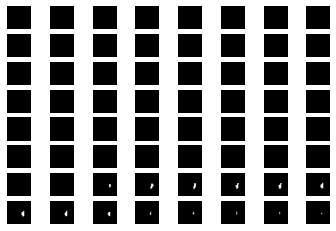

In [69]:
I = np.load('/content/drive/MyDrive/DOCTORADO/python/aug/imgs/aug_img_2A3.npy')
J = np.load('/content/drive/MyDrive/DOCTORADO/python/aug/masks/aug_mask_2A3.npy')

plt.subplot(1,2,1)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(J[:,:,i,0],cmap='gray')
  plt.axis('off')

In [ ]:
print(type(img[0,0,0,0,0]))
print(type(mask[0,0,0,0,0]))

<class 'numpy.float32'>
<class 'numpy.float32'>


In [ ]:
temp = img[0,0,0,0,0]
print(temp) 
temp32 = temp.astype(np.float32)
print(temp32) 
temp16 = temp.astype(np.float16)
print(temp16) 

74.11547
74.11547
74.1


In [ ]:
def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256) #Bridge

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    activation = 'sigmoid'

    outputs = Conv3D(1, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(f'activation function: {activation}')

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet((64, 64, 64, 1))
print(f'model input shape: {model.input_shape}')

activation function: sigmoid
model input shape: (None, 64, 64, 64, 1)


In [ ]:
!pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 


In [ ]:
from segmentation_models_3D.losses import BinaryCELoss
import segmentation_models_3D as sm
from keras import backend as K

'''
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
'''
#dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.BinaryFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

iou = tf.keras.metrics.MeanIoU(num_classes=2)

metrics = [iou, sm.metrics.FScore(), sm.metrics.Precision(), sm.metrics.Recall()]
#jaccard_loss = sm.losses.JaccardLoss()


Segmentation Models: using `tf.keras` framework.


In [ ]:
LR = 0.1
optim = keras.optimizers.Adam(LR)

loss = 'BinaryCrossentropy'

model.compile(optimizer=optim, loss=loss ,metrics = metrics)
print(model.summary())
print(f'LR = {LR}')
print(loss)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_19 (Conv3D)             (None, 64, 64, 64,   448         ['input_2[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 64,   64         ['conv3d_19[0][0]']              
 ormalization)                  16)                                                           

In [ ]:
#Si uso el custom datagen
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('UNet_aneurismas_patches.hdf5')

Epoch 1/40
36/36 [==============================] - 79s 2s/step - loss: 5.6096e-04 - mean_io_u: 0.5000 - f1-score: 1.7246e-05 - precision: 4.0867e-05 - recall: 0.6111 - val_loss: 0.0065 - val_mean_io_u: 0.5000 - val_f1-score: 0.1985 - val_precision: 0.4283 - val_recall: 0.5000
Epoch 2/40
36/36 [==============================] - 73s 2s/step - loss: 4.3644e-04 - mean_io_u: 0.5000 - f1-score: 1.8669e-05 - precision: 3.2299e-05 - recall: 0.6111 - val_loss: 0.0199 - val_mean_io_u: 0.5000 - val_f1-score: 6.5335e-05 - val_precision: 9.8497e-05 - val_recall: 0.5000
Epoch 3/40
36/36 [==============================] - 74s 2s/step - loss: 3.9345e-04 - mean_io_u: 0.5000 - f1-score: 1.8644e-05 - precision: 4.4635e-05 - recall: 0.6111 - val_loss: 2.2621e-04 - val_mean_io_u: 0.5000 - val_f1-score: 4.1891e-06 - val_precision: 1.1460e-05 - val_recall: 0.5000
Epoch 4/40
36/36 [==============================] - 72s 2s/step - loss: 3.9417e-04 - mean_io_u: 0.5000 - f1-score: 1.8420e-05 - precision: 4.5661e

In [ ]:
model.save('/content/drive/MyDrive/DOCTORADO/2 Semestre/Pruebas modelos DL/history models/UNet_aneurismas_patches.hdf5')

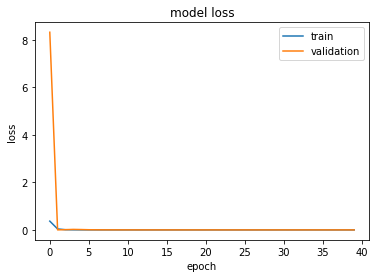

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
y_pred=model.predict(X_test)
#y_pred = y_pred >= 0.5 
#y_pred = y_pred.astype(int)
print(y_pred.shape)
print(np.unique(y_pred))

In [ ]:
print(np.unique(y_test[38,:,:,26,:]))

In [ ]:
plt.subplot(1,3,1)
plt.imshow(X_test[38,:,:,26,0],cmap='gray');
plt.subplot(1,3,2)
plt.imshow(y_test[38,:,:,26,0],cmap='gray');
plt.subplot(1,3,3)
plt.imshow(y_pred[38,:,:,26,0],cmap='gray');